In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm  #  tqdm is a Python library for adding progress bar

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [14]:
BASE_DIR = '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected'

In [15]:
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR,image_name)
    image_paths.append(image_path)


In [16]:
len(image_paths)

13780

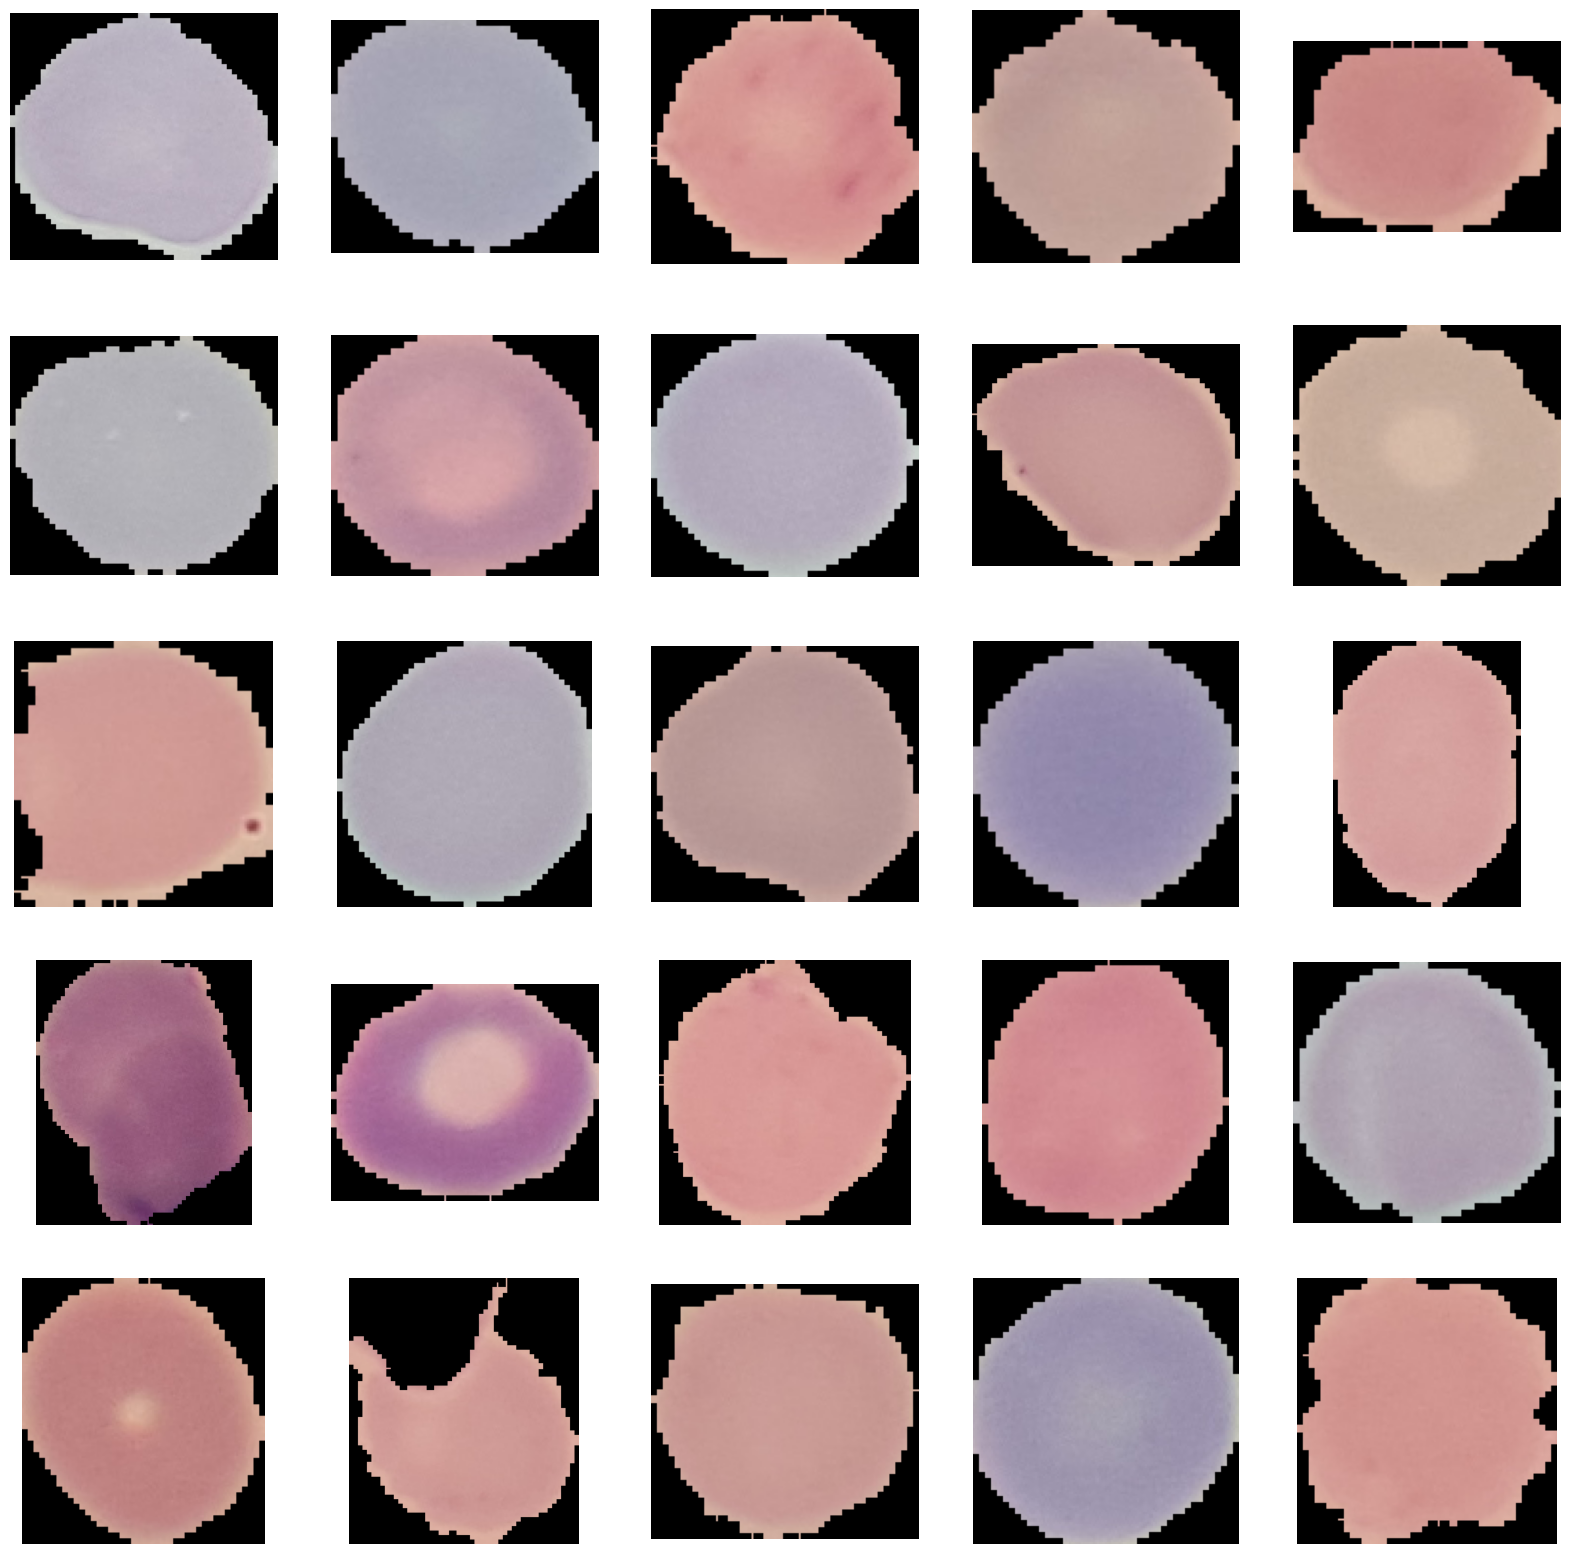

In [17]:
plt.figure(figsize=(20,20))
temp_images = image_paths[:25]
index = 1

for image_path in temp_images:
    plt.subplot(5,5,index)
    img = load_img(image_path)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
    index +=1

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm

2024-02-11 04:11:28.297616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 04:11:28.297716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 04:11:28.431372: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Define the directory path containing images
directory_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected"

In [5]:
# Get a list of file names in the directory
image_files = os.listdir(directory_path)

# Create a list of image paths by joining directory path with file names
image_paths = [os.path.join(directory_path, file_name) for file_name in image_files]

target_shape = (64, 64)  # Define the target shape for resizing

# Function to load images, resize them, and convert them to numpy arrays
def load_and_resize_images(image_paths, target_shape):
    image_arrays = []
    for path in tqdm(image_paths):
        try:
            # Load image using load_img from Keras
            img = load_img(path)
            # Resize image to target shape
            resized_img = tf.image.resize(img_to_array(img), target_shape)
            # Append the resized image array to the list
            image_arrays.append(resized_img)
        except Exception as e:
            print(f"Error loading image '{path}': {e}")
    return image_arrays

# Call the function with the list of image paths
train_images = load_and_resize_images(image_paths, target_shape)

# Convert the list of arrays to a single numpy array
train_images = np.array(train_images)

# Check the shape of the first image to confirm they all have the same shape
print("Shape of all images after resizing:", train_images.shape[1:])



 66%|██████▋   | 9145/13780 [00:20<00:17, 263.51it/s]

Error loading image '/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected/Thumbs.db': cannot identify image file <_io.BytesIO object at 0x7cbd945255d0>


100%|██████████| 13780/13780 [01:26<00:00, 159.45it/s]


Shape of all images after resizing: (64, 64, 3)


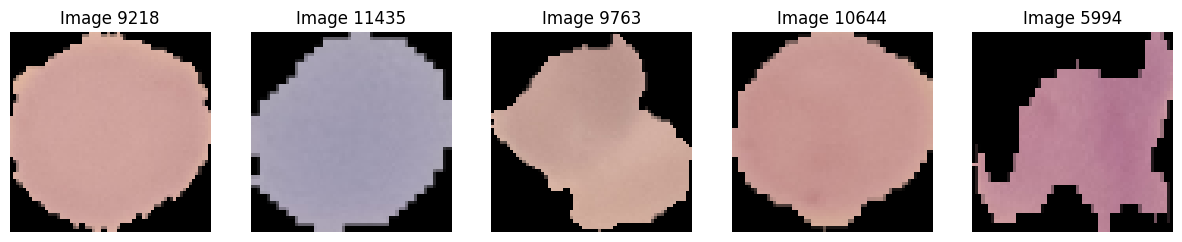

In [6]:
import matplotlib.pyplot as plt

# Function to visualize images
def visualize_images(images, num_images=5):
    # Randomly select num_images from the dataset
    selected_images = np.random.choice(images.shape[0], num_images, replace=False)
    
    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, idx in enumerate(selected_images):
        axes[i].imshow(images[idx].astype('uint8'))  # Convert to uint8 for imshow
        axes[i].axis('off')
        axes[i].set_title(f"Image {idx}")
    plt.show()

# Visualize the reshaped images
visualize_images(train_images)



In [8]:
train_images = (train_images - 127.5) / 127.5

In [9]:
train_images[0]

array([[[-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        ...,
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431]],

       [[-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        ...,
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431]],

       [[-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        ...,
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431]],

       ...,

       [[-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -1.0078431, -1.0078431],
        [-1.0078431, -

In [18]:
LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

In [19]:
# Generator Model will create new images similar to training data from random noise

model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

In [20]:
# Discriminator model will classify the image from the generator to check whether it real (or) fake images

model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [21]:
# Create DCGAN

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')
        
    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]
    
    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)
            
            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            
            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2
            
        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        
        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)
            
        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))
        
        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        
        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [24]:
# Next we will plot some images for each epoch

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()
        
        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()
        
    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [25]:
# Now let us initialize the DCGAN model 

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [26]:
# Next let us compile the DCGAN model

D_LR = 0.0001 
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

Epoch 1/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6283 - g_loss: 1.2966

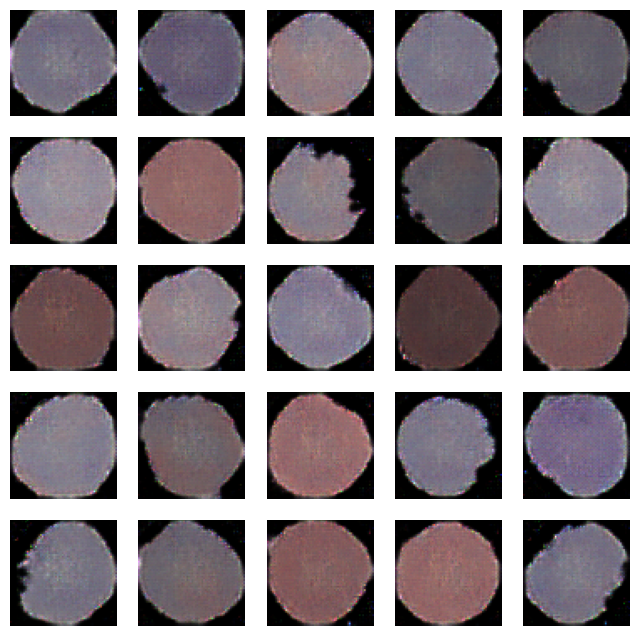

431/431 [==============================] - 19s 43ms/step - d_loss: 0.6283 - g_loss: 1.2966
Epoch 2/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6301 - g_loss: 1.3323

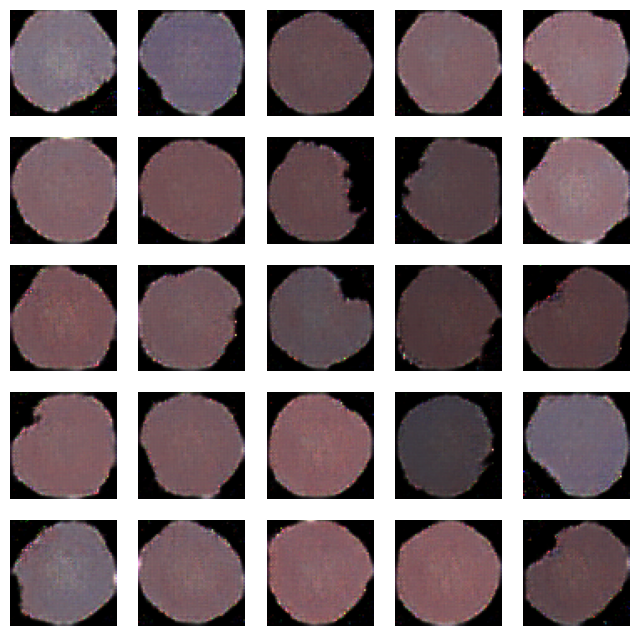

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6301 - g_loss: 1.3323
Epoch 3/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6359 - g_loss: 1.2916

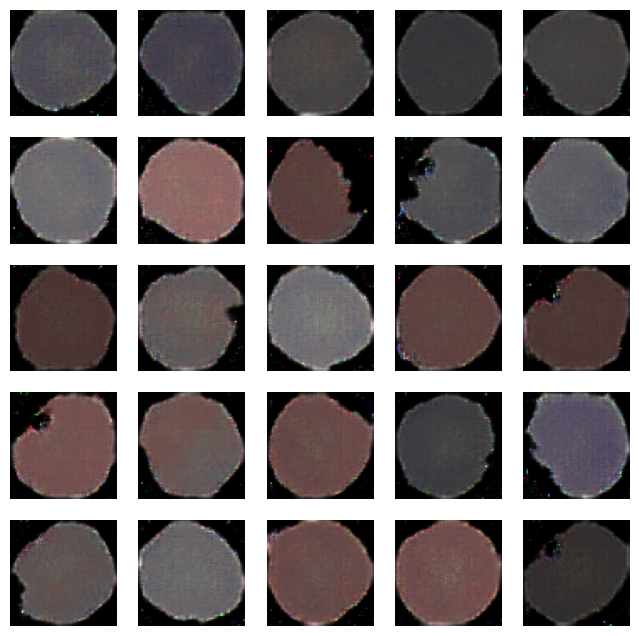

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6359 - g_loss: 1.2916
Epoch 4/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6596 - g_loss: 1.0953

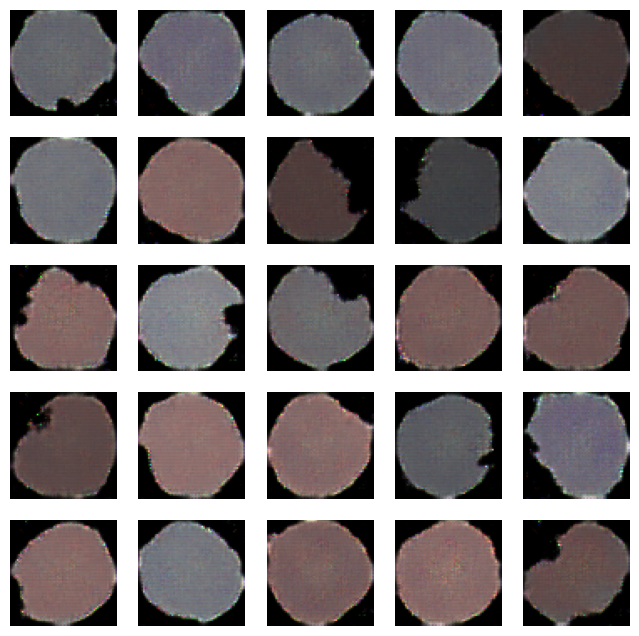

431/431 [==============================] - 18s 43ms/step - d_loss: 0.6596 - g_loss: 1.0953
Epoch 5/10
430/431 [============================>.] - ETA: 0s - d_loss: 0.6505 - g_loss: 1.2058

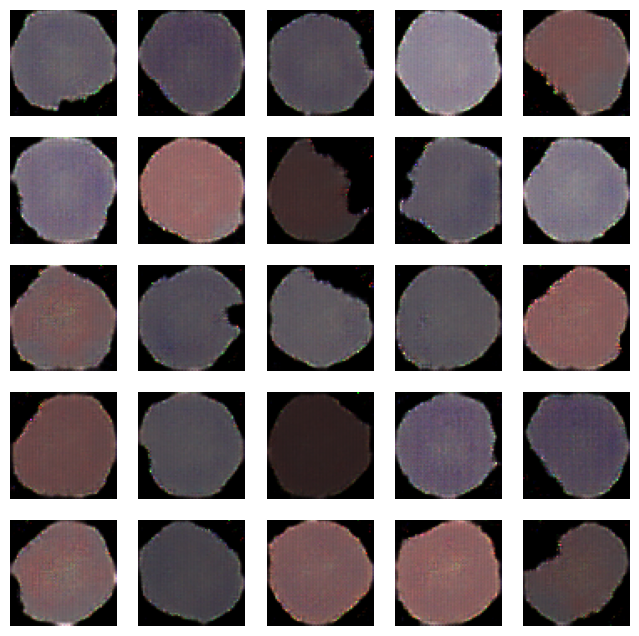

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6507 - g_loss: 1.2071
Epoch 6/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6480 - g_loss: 1.2279

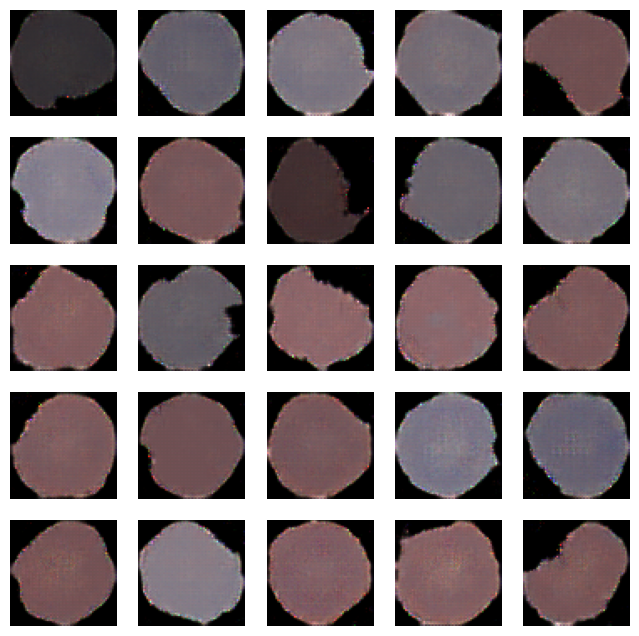

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6480 - g_loss: 1.2279
Epoch 7/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6651 - g_loss: 1.1424

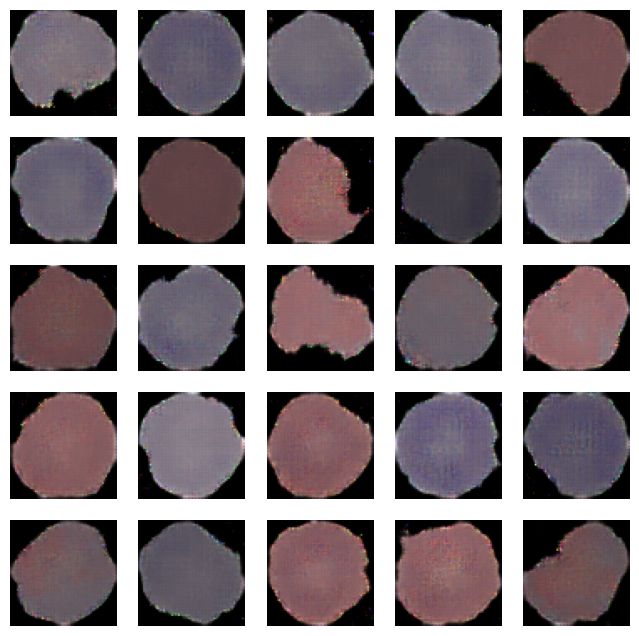

431/431 [==============================] - 18s 43ms/step - d_loss: 0.6651 - g_loss: 1.1424
Epoch 8/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6666 - g_loss: 1.0246

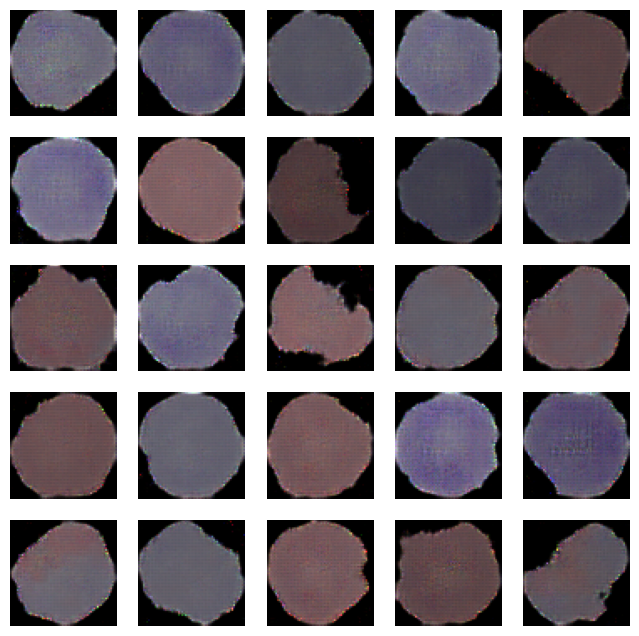

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6666 - g_loss: 1.0246
Epoch 9/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6627 - g_loss: 1.1272

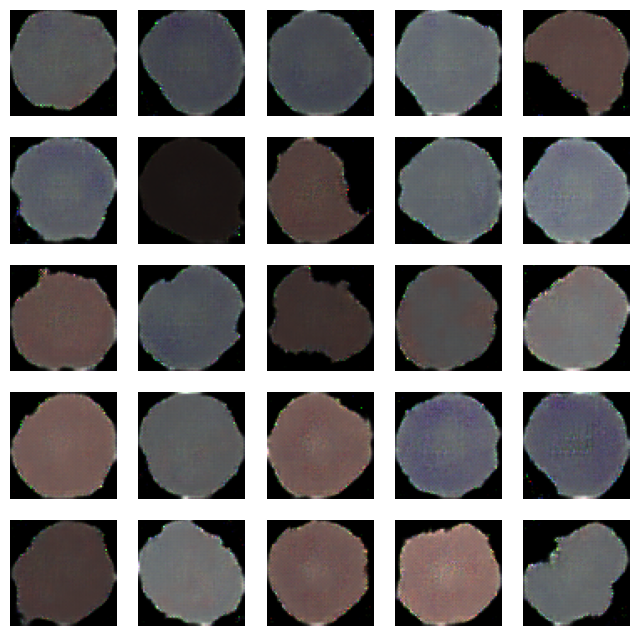

431/431 [==============================] - 18s 42ms/step - d_loss: 0.6627 - g_loss: 1.1272
Epoch 10/10
431/431 [==============================] - ETA: 0s - d_loss: 0.6569 - g_loss: 1.0961

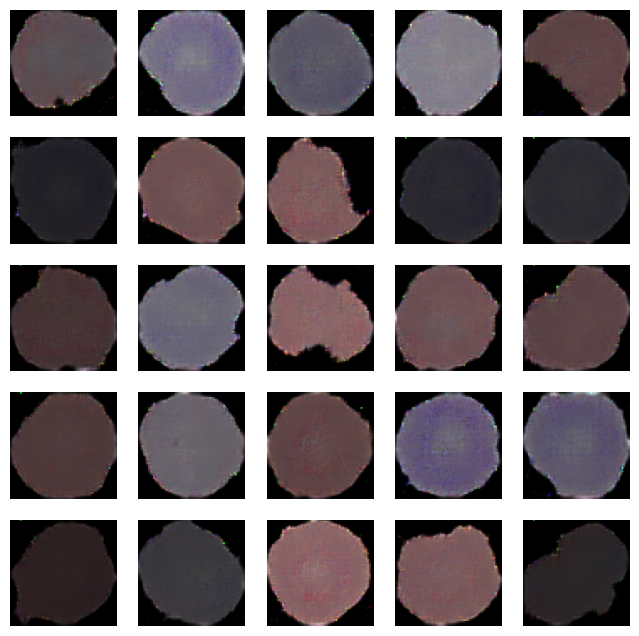

431/431 [==============================] - 18s 43ms/step - d_loss: 0.6569 - g_loss: 1.0961


In [28]:
# Next we will train the model

N_EPOCHS = 10
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

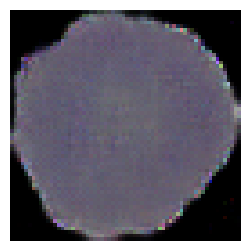

In [30]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()